# CGAN
   ConditionalGAN顾名思义是条件GAN，就是给GAN增加一个条件。具体是怎么回事呢？看代码：
这段代码使用mnist数据集，来生成手写数字。以下代码可以直接正确运行。

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 读入数据
MNIST数据集

In [2]:
mnist = input_data.read_data_sets('/MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128

Extracting /MNIST_data\train-images-idx3-ubyte.gz
Extracting /MNIST_data\train-labels-idx1-ubyte.gz
Extracting /MNIST_data\t10k-images-idx3-ubyte.gz
Extracting /MNIST_data\t10k-labels-idx1-ubyte.gz


### 变量初始化和Placeholder

In [3]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

### 定义判别器
与普通的GAN没有区别，从下边开始可以看到discriminator除了输入原来的x，还输入了一个y。这个y就是我们所说的condition。接下来的generator也一样，多了一个y。

In [4]:
def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

### 定义生成器

In [5]:
def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


# 输出训练中间的结果
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [6]:
G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

### Loss函数和优化器

In [7]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

### 训练
每1000次迭代输出一次标签7的结果

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(100000):
    if it % 1000 == 0:
        n_sample = 16

        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, 7] = 1

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, y_mb = mnist.train.next_batch(mb_size)

    Z_sample = sample_Z(mb_size, Z_dim)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})


    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()


Iter: 0
D loss: 1.621
G_loss: 2.897

Iter: 1000
D loss: 0.005972
G_loss: 9.368

Iter: 2000
D loss: 0.03242
G_loss: 5.243

Iter: 3000
D loss: 0.04928
G_loss: 5.483

Iter: 4000
D loss: 0.1226
G_loss: 4.042

Iter: 5000
D loss: 0.07861
G_loss: 7.295

Iter: 6000
D loss: 0.2262
G_loss: 5.127

Iter: 7000
D loss: 0.2472
G_loss: 5.051

Iter: 8000
D loss: 0.3334
G_loss: 4.061

Iter: 9000
D loss: 0.3491
G_loss: 4.19

Iter: 10000
D loss: 0.4331
G_loss: 2.997

Iter: 11000
D loss: 0.5278
G_loss: 3.451

Iter: 12000
D loss: 0.4697
G_loss: 2.805

Iter: 13000
D loss: 0.5265
G_loss: 3.131

Iter: 14000
D loss: 0.6893
G_loss: 2.87

Iter: 15000
D loss: 0.7593
G_loss: 2.341

Iter: 16000
D loss: 0.8354
G_loss: 2.103

Iter: 17000
D loss: 0.6545
G_loss: 1.978

Iter: 18000
D loss: 0.8382
G_loss: 2.398

Iter: 19000
D loss: 0.5676
G_loss: 2.335

Iter: 20000
D loss: 0.6985
G_loss: 2.134

Iter: 21000
D loss: 0.8371
G_loss: 2.023

Iter: 22000
D loss: 0.8265
G_loss: 1.92

Iter: 23000
D loss: 0.6487
G_loss: 1.977

Iter

通过训练好的CGAN生成数字9

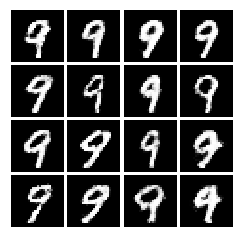

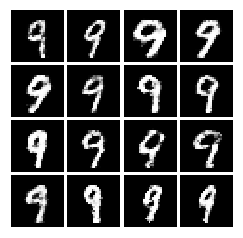

In [12]:
Z_sample = sample_Z(n_sample, Z_dim)
y_sample = np.zeros(shape=[n_sample, y_dim])
y_sample[:, 9] = 1 # c = 9
samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
fig = plot(samples)
plt.show()